### Import libraries

In [15]:
import os
import sys
from datetime import datetime
import re
import yaml
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import seaborn as sns
from scipy.stats import ks_2samp, gaussian_kde
from scipy.stats import ttest_ind
from statsmodels.distributions.empirical_distribution import ECDF
import h5py as h5

# Add the parent directory of current directory to the Python path
sys.path.insert(0, os.path.abspath('..'))

from src.utils.process_session import *
from src.utils.optostim import *

### Set folder locations for analysed behaviour and keypoint data 

In [16]:
# folder locations for analysed data
Experiment = "DLS_GtACR_opto-inhibition"
Animals = ["SP108", "SP110", "SP112", "SP148", "SP149", "SP151", "SP152", "SP153"] ## "SP150"
Group = ["DLS-GtACR", "DLS-GtACR", "DLS-GtACR", "DLS-GtACR", "DLS-GtACR", "DLS-GtACR", "DLS-GtACR", "DLS-GtACR"]
Camera_Folder = "/Volumes/sjones/projects/sequences/SP_FlyCap"
data_Folder = "/Users/sthitapati/Library/CloudStorage/GoogleDrive-sthita.pati@gmail.com/My Drive/analysed_data"
deeplabcut_folder = "/Users/sthitapati/Library/CloudStorage/GoogleDrive-sthita.pati@gmail.com/My Drive/analysed_data/deeplabcut_keypoints"

# output folder is in data_folder/analysed_data/behaviour_output/Experiment
Output_Folder = os.path.join(data_Folder, "behaviour_output", Experiment)


In [17]:
# save path for figures
save_folder = os.path.join(Output_Folder, "plots")
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
    print("Created folder: ", save_folder)
else:
    print("Folder already exists: ", save_folder)

Folder already exists:  /Users/sthitapati/Library/CloudStorage/GoogleDrive-sthita.pati@gmail.com/My Drive/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/plots


In [18]:
test_animal = "SP153"

### Load files from deeplabcut_folder + test_animal


In [19]:

path_to_dlc = os.path.join(deeplabcut_folder, test_animal, "predictions")

print(f'path_to_dlc: {path_to_dlc}')

# list all h5 files in the folder
h5_files = [f for f in os.listdir(path_to_dlc) if f.endswith('.h5')]

print(h5_files)

path_to_dlc: /Users/sthitapati/Library/CloudStorage/GoogleDrive-sthita.pati@gmail.com/My Drive/analysed_data/deeplabcut_keypoints/SP153/predictions
['camera12024-01-14T14_05_36DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-02T13_11_53DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-29T12_26_56DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-11T12_00_00DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-19T12_58_41DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-13T13_19_20DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-09T12_37_00DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-05T11_40_32DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-16T12_10_14DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5', 'camera12024-01-04T12_59_31DLC_resnet50_s

In [20]:
# write a function to read the dates of the video from the h5 filenames (can be one name or a list of names)
# e.g. camera12024-02-02T12_19_31DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5 is recorded on 2024-02-02
import re

def get_date_from_h5(h5_filenames):
    """Extracts the recording date from h5 filenames in the format
       camera12024-02-02T12_19_31DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5

    Args:
        h5_filenames: A single h5 filename (str) or a list of filenames (list).

    Returns:
        If a single filename is provided: The date as a string in the format YYYY-MM-DD
        If a list of filenames is provided: A list of corresponding dates.  
    """

    date_pattern = r"\d{4}-\d{2}-\d{2}"  # Pattern for YYYY-MM-DD

    if isinstance(h5_filenames, str):  # Handle a single filename
        match = re.search(date_pattern, h5_filenames)
        if match:
            return match.group(0)
        else:
            return None  # Date not found in filename

    elif isinstance(h5_filenames, list):  # Handle a list of filenames
        dates = []
        for filename in h5_filenames:
            match = re.search(date_pattern, filename)
            if match:
                dates.append(match.group(0))
            else:
                dates.append(None)  # Indicate date not found
        return dates

    else:
        raise TypeError("Input must be a string or a list of strings.")


    
# h5_filename = 'camera12024-02-02T12_19_31DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5'

# print(get_date_from_h5(h5_filename))


In [21]:
test_date = datetime(2024, 2, 2)

# get the h5 file for the test date
h5_file = [f for f in h5_files if get_date_from_h5(f) == test_date.strftime("%Y-%m-%d")][0]
print(h5_file)


camera12024-02-02T12_19_31DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5


In [22]:
# read the h5 file
h5_path = os.path.join(path_to_dlc, h5_file)
print(h5_path)

# read the h5 file into a pandas dataframe

keypoints_df = pd.read_hdf(h5_path)
keypoints_df.head()


/Users/sthitapati/Library/CloudStorage/GoogleDrive-sthita.pati@gmail.com/My Drive/analysed_data/deeplabcut_keypoints/SP153/predictions/camera12024-02-02T12_19_31DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000.h5


scorer    DLC_resnet50_seq_8_keypoints_thethredFeb27shuffle1_100000  \
bodyparts                                                      nose   
coords                                                            x   
0                                                 620.881165          
1                                                 616.764099          
2                                                 607.609497          
3                                                 602.738586          
4                                                 597.708313          

scorer                                                               \
bodyparts                           left_ear                          
coords              y likelihood           x           y likelihood   
0          481.748901   0.953009  633.361877  504.023560   0.985210   
1          482.719208   0.968829  632.200439  505.719574   0.973077   
2          485.946228   0.980020  628.463928  517.784729   0.993570   
3          488.755829   0.992428  625.910095  519.122986   0.993019   
4          489.157867   0.986449  624.436340  522.389832   0.991209   

scorer                                                       ...  \
bodyparts   right_ear                        cervical_spine  ...   
coords              x           y likelihood              x  ...   
0          700.170715  455.756409   0.977663     659.870850  ...   
1          692.846558  454.841370   0.982573     655.843811  ...   
2          688.712585  456.000214   0.951885     651.832275  ...   
3          677.118164  458.600525   0.894257     648.242554  ...   
4          656.443665  462.542236   0.833018     641.823242  ...   

scorer                                                                    \
bodyparts thorasic_spine lumbar_spine                          tail_base   
coords        likelihood            x           y likelihood           x   
0               0.961540   716.264648  542.972717   0.985548  729.514038   
1               0.942667   717.568054  542.943665   0.984973  730.253723   
2               0.935787   719.489685  541.536804   0.984458  729.583923   
3               0.932344   718.816528  540.465210   0.983490  729.838562   
4               0.929480   718.759827  537.995178   0.982370  729.936035   

scorer                                                               
bodyparts                           tail_tip                         
coords              y likelihood           x           y likelihood  
0          602.766724   0.996009  914.706116  704.482178   0.996073  
1          602.540039   0.995967  915.131958  704.591431   0.996228  
2          602.381348   0.995862  915.044678  704.099915   0.994855  
3          601.644043   0.995791  915.135681  704.432861   0.995063  
4          601.371216   0.996394  914.713074  704.314453   0.994089  

[5 rows x 24 columns]

In [23]:
# make a copy of the dataframe
test_df = keypoints_df.copy()

# remove the first level of the multiindex
test_df.columns = test_df.columns.droplevel(0)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215317 entries, 0 to 215316
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   (nose, x)                     215317 non-null  float64
 1   (nose, y)                     215317 non-null  float64
 2   (nose, likelihood)            215317 non-null  float64
 3   (left_ear, x)                 215317 non-null  float64
 4   (left_ear, y)                 215317 non-null  float64
 5   (left_ear, likelihood)        215317 non-null  float64
 6   (right_ear, x)                215317 non-null  float64
 7   (right_ear, y)                215317 non-null  float64
 8   (right_ear, likelihood)       215317 non-null  float64
 9   (cervical_spine, x)           215317 non-null  float64
 10  (cervical_spine, y)           215317 non-null  float64
 11  (cervical_spine, likelihood)  215317 non-null  float64
 12  (thorasic_spine, x)           215317 non-null  fl

In [24]:
print(test_df.columns)

MultiIndex([(          'nose',          'x'),
            (          'nose',          'y'),
            (          'nose', 'likelihood'),
            (      'left_ear',          'x'),
            (      'left_ear',          'y'),
            (      'left_ear', 'likelihood'),
            (     'right_ear',          'x'),
            (     'right_ear',          'y'),
            (     'right_ear', 'likelihood'),
            ('cervical_spine',          'x'),
            ('cervical_spine',          'y'),
            ('cervical_spine', 'likelihood'),
            ('thorasic_spine',          'x'),
            ('thorasic_spine',          'y'),
            ('thorasic_spine', 'likelihood'),
            (  'lumbar_spine',          'x'),
            (  'lumbar_spine',          'y'),
            (  'lumbar_spine', 'likelihood'),
            (     'tail_base',          'x'),
            (     'tail_base',          'y'),
            (     'tail_base', 'likelihood'),
            (      'tail_tip',    

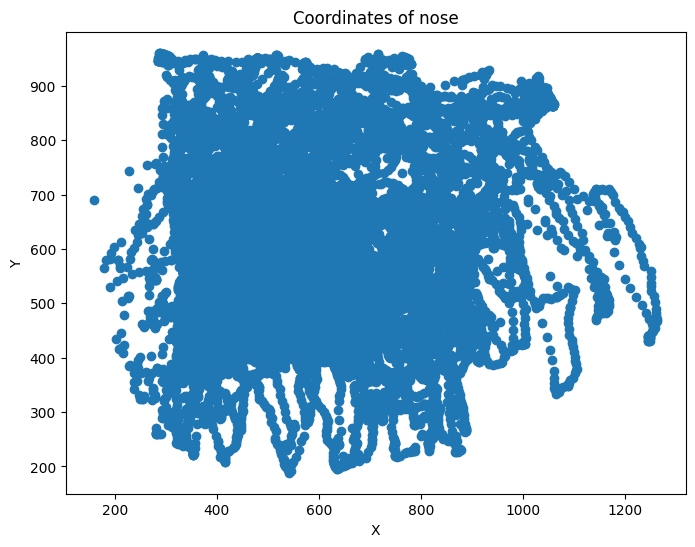

In [25]:
body_part = 'nose'

x_data = test_df[body_part, 'x']
y_data = test_df[body_part, 'y']

plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.scatter(x_data, y_data)
plt.title(f'Coordinates of {body_part}')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [26]:
# now loop through all Animals and concat the dataframes to create allsessions_DF

for i, current_animal in enumerate(Animals):
    print(current_animal)
    all_sessions_file_name = os.path.join(Output_Folder, current_animal, f'{current_animal}_transition_data_all_sessions.csv')
    print(all_sessions_file_name)
    current_DF = pd.read_csv(all_sessions_file_name)
    if i == 0:
        allsessions_DF = current_DF
    else:
        allsessions_DF = pd.concat([allsessions_DF, current_DF], axis=0)

allsessions_DF.head()

SP108
/Users/sthitapati/Library/CloudStorage/GoogleDrive-sthita.pati@gmail.com/My Drive/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/SP108/SP108_transition_data_all_sessions.csv
SP110
/Users/sthitapati/Library/CloudStorage/GoogleDrive-sthita.pati@gmail.com/My Drive/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/SP110/SP110_transition_data_all_sessions.csv
SP112
/Users/sthitapati/Library/CloudStorage/GoogleDrive-sthita.pati@gmail.com/My Drive/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/SP112/SP112_transition_data_all_sessions.csv
SP148
/Users/sthitapati/Library/CloudStorage/GoogleDrive-sthita.pati@gmail.com/My Drive/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/SP148/SP148_transition_data_all_sessions.csv
SP149
/Users/sthitapati/Library/CloudStorage/GoogleDrive-sthita.pati@gmail.com/My Drive/analysed_data/behaviour_output/DLS_GtACR_opto-inhibition/SP149/SP149_transition_data_all_sessions.csv
SP151
/Users/sthitapati/Library/CloudStorage/Googl

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,camera_port_in_times,camera_port_out_times,camera_trial_start_times,camera_trial_end_times,cumulative_trial_id,session_id,date,day,animal_id,group
0,0,1,33,3,3,252.4712,252.4845,252.4927,254.1755,0.0082,...,NaN,NaN,NaN,NaN,1,0,2023-04-21,Fri,SP108,Control
1,1,1,37,3,7,252.4927,254.1755,319.3230,320.5142,65.1475,...,NaN,NaN,NaN,NaN,1,0,2023-04-21,Fri,SP108,Control
2,2,1,73,7,3,319.3230,320.5142,321.0197,321.0275,0.5055,...,NaN,NaN,NaN,NaN,1,0,2023-04-21,Fri,SP108,Control
3,3,1,33,3,3,321.0197,321.0275,321.0635,321.1840,0.0360,...,NaN,NaN,NaN,NaN,1,0,2023-04-21,Fri,SP108,Control
4,4,1,37,3,7,321.0635,321.1840,328.9522,330.1291,7.7682,...,NaN,NaN,NaN,NaN,1,0,2023-04-21,Fri,SP108,Control


In [27]:
# get session settings loop through all Animals and concat the dataframes to create session_settings_DF
# append name of current animal to the session_settings_DF
# ignore .DS_Store files

for i, current_animal in enumerate(Animals):
    print(current_animal)
    current_DF = get_session_details(Output_Folder, current_animal)
    current_DF['Animal'] = current_animal
    if i == 0:
        session_details_DF = current_DF
    else:
        session_details_DF = pd.concat([session_details_DF, current_DF], axis=0)

session_details_DF.head()

SP108
SP110
SP112
SP148
SP149
SP151
SP152
SP153


,session_id,session,date,file_number,day,opto_session,stim_port,opto_chance,pulse_duration,pulse_interval,train_duration,train_delay,variable_train_delay,mu_variable_delay,sigma_variable_delay,lower_bound_variableDelay,upper_bound_variableDelay,experiment_type,Animal
0,0,00_20230421_104635_Fri,2023-04-21,104635,Fri,False,None,None,None,None,None,None,False,None,None,None,None,1_Training,SP108
1,1,01_20230422_142310_Sat,2023-04-22,142310,Sat,False,None,None,None,None,None,None,False,None,None,None,None,1_Training,SP108
2,2,02_20230422_142611_Sat,2023-04-22,142611,Sat,False,None,None,None,None,None,None,False,None,None,None,None,1_Training,SP108
3,3,03_20230423_181053_Sun,2023-04-23,181053,Sun,False,None,None,None,None,None,None,False,None,None,None,None,1_Training,SP108
4,4,04_20230424_110840_Mon,2023-04-24,110840,Mon,False,None,None,None,None,None,None,False,None,None,None,None,1_Training,SP108


In [38]:
# get the behaviour data for the test animal on test_date

test_behaviour_df = allsessions_DF[(allsessions_DF['animal_id'] == test_animal) & (allsessions_DF['date'] == test_date.strftime("%Y-%m-%d"))]
test_behaviour_df.head()

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,camera_port_in_times,camera_port_out_times,camera_trial_start_times,camera_trial_end_times,cumulative_trial_id,session_id,date,day,animal_id,group
183546,0,1,63,6,3,38.7861,39.2174,39.5835,39.6272,0.3661,...,169.355375,169.786675,174.160875,177.94225,25526,57,2024-02-02,Fri,SP153,Control
183547,1,1,37,3,7,39.5835,39.6272,39.9339,40.0218,0.3067,...,170.152775,170.196475,174.160875,177.94225,25526,57,2024-02-02,Fri,SP153,Control
183548,2,1,77,7,7,39.9339,40.0218,40.1257,40.2348,0.1039,...,170.503175,170.591075,174.160875,177.94225,25526,57,2024-02-02,Fri,SP153,Control
183549,3,1,73,7,3,40.1257,40.2348,40.6973,40.7591,0.4625,...,170.694975,170.804075,174.160875,177.94225,25526,57,2024-02-02,Fri,SP153,Control
183550,4,1,33,3,3,40.6973,40.7591,41.3123,41.5375,0.5532,...,171.266575,171.328375,174.160875,177.94225,25526,57,2024-02-02,Fri,SP153,Control


In [40]:
# get all non-stimulated trials when test_behaviour_df['opto_condition is not 1
nonstim_df = test_behaviour_df[test_behaviour_df['opto_condition'] != 1]
nonstim_df.head()

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,camera_port_in_times,camera_port_out_times,camera_trial_start_times,camera_trial_end_times,cumulative_trial_id,session_id,date,day,animal_id,group
183546,0,1,63,6,3,38.7861,39.2174,39.5835,39.6272,0.3661,...,169.355375,169.786675,174.160875,177.94225,25526,57,2024-02-02,Fri,SP153,Control
183547,1,1,37,3,7,39.5835,39.6272,39.9339,40.0218,0.3067,...,170.152775,170.196475,174.160875,177.94225,25526,57,2024-02-02,Fri,SP153,Control
183548,2,1,77,7,7,39.9339,40.0218,40.1257,40.2348,0.1039,...,170.503175,170.591075,174.160875,177.94225,25526,57,2024-02-02,Fri,SP153,Control
183549,3,1,73,7,3,40.1257,40.2348,40.6973,40.7591,0.4625,...,170.694975,170.804075,174.160875,177.94225,25526,57,2024-02-02,Fri,SP153,Control
183550,4,1,33,3,3,40.6973,40.7591,41.3123,41.5375,0.5532,...,171.266575,171.328375,174.160875,177.94225,25526,57,2024-02-02,Fri,SP153,Control


In [48]:
# get a random trail id from nonstim_df

trial_id = 12
# print(trial_id)

trial_df = nonstim_df[nonstim_df['trial_id'] == trial_id]
trial_df.head()

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,camera_port_in_times,camera_port_out_times,camera_trial_start_times,camera_trial_end_times,cumulative_trial_id,session_id,date,day,animal_id,group
183632,86,12,21,2,1,101.3168,101.4049,101.7641,101.8027,0.3592,...,231.896875,231.984975,231.896875,235.411625,25537,57,2024-02-02,Fri,SP153,Control
183633,87,12,13,1,3,101.7641,101.8027,102.9132,102.9267,1.1105,...,232.344175,232.382775,231.896875,235.411625,25537,57,2024-02-02,Fri,SP153,Control
183634,88,12,36,3,6,102.9132,102.9267,103.3397,103.5354,0.4130,...,233.493275,233.506775,231.896875,235.411625,25537,57,2024-02-02,Fri,SP153,Control
183635,89,12,63,6,3,103.3397,103.5354,104.1219,104.1220,0.5865,...,233.919775,234.115475,231.896875,235.411625,25537,57,2024-02-02,Fri,SP153,Control
183636,90,12,33,3,3,104.1219,104.1220,104.1224,104.1631,0.0004,...,234.701975,234.702075,231.896875,235.411625,25537,57,2024-02-02,Fri,SP153,Control


In [53]:
camera_start = trial_df['camera_trial_start_times'].values[0]
camera_end = trial_df['camera_trial_end_times'].values[0]

next_trial_camera_start = test_behaviour_df[test_behaviour_df['trial_id'] == trial_id + 1]['camera_trial_start_times'].values[0]

print(camera_start, camera_end)
print(next_trial_camera_start)

231.896875 235.411625
237.06075


In [58]:
# now the aim is to exctract the frames that correspond to the trial from the video
# convert frmae numbers to numpy array
# row numbers of test_df that correspond to the frame numbers

frame_numbers = test_df.index.get_level_values(0).to_numpy()



[     0      1      2 ... 215314 215315 215316]


In [63]:
# load files from timestamps folder inside Output_Folder+current_animal+deeplabcut_folder

timestamps_folder = os.path.join(deeplabcut_folder, test_animal, "timestamps")
#check if the folder exists
if not os.path.exists(timestamps_folder):
    print(f"Folder does not exist: {timestamps_folder}")

Folder does not exist: /Users/sthitapati/Library/CloudStorage/GoogleDrive-sthita.pati@gmail.com/My Drive/analysed_data/deeplabcut_keypoints/SP153/timestamps
